In [13]:
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import clear_output
import time
import copy
from scipy.spatial import Voronoi, voronoi_plot_2d
import gurobipy as gp
from gurobipy import GRB

In [14]:
# geodata = pd.read_csv('CommunityClubsTest-clean.csv')
# print(geodata)
# bloodbankcoords = pd.read_csv('HSA bloodbank coordinates1.csv')
# print(bloodbankcoords)
# privhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Private_Hospital (3).csv")
# pubhospcoords = pd.read_csv("Plot_of_Hospitals,_Blood_Banks_&_Community_Centers_Public_Hospital (3).csv")

In [15]:
# # y-coordinates/latitude of CCs, BBs and hospitals
# y_coordCC = geodata['Y']
# y_coordBB = bloodbankcoords['Latitude']
# y_coord_privhosp = privhospcoords['Latitude']
# y_coord_pubhosp = pubhospcoords['Latitude']

# # x-coordinates/longitude of CCs, BBs and hospitals
# x_coordCC = geodata['X']
# x_coordBB = bloodbankcoords['Longitude']
# x_coord_privhosp = privhospcoords['Longitude']
# x_coord_pubhosp = pubhospcoords['Longitude']


# #no. of BBs
# nbrblood = 5

# #no. of CCs
# nbrcomm = 125

# #no. of private hosps
# nbrprivh = 9

# #no. of public hosps
# nbrpubh = 10

# #radius of earth
# R = 6371


# def deg_to_rad(degrees):
#     return degrees*(np.pi/180)

# # distance calculations between CC and BBs
# distancelct=np.empty([nbrblood, nbrcomm])
# for i_index in range(nbrblood):
#     for j_index in range(nbrcomm):
#         d_lon = deg_to_rad(x_coordBB[i_index]-x_coordCC[j_index])
#         d_lat = deg_to_rad(y_coordBB[i_index]-y_coordCC[j_index])
#         a = np.sin(d_lat/2)**2 +np.cos(deg_to_rad(x_coordBB[i_index])) * np.cos(deg_to_rad(x_coordCC[j_index])) * np.sin(d_lon/2)**2
#         c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
#         distancelct[i_index,j_index] = R*c

# # print(distancelct)

# # Distance calculation between BBs and private hospitals
# distanceBB_priv = np.empty((nbrblood, nbrprivh))

# for i_index in range(nbrblood):  # loop over blood banks
#     for h_index in range(nbrprivh):  # loop over private hospitals
#         d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_privhosp[h_index])
#         d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_privhosp[h_index])
#         a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_privhosp[h_index])) * np.sin(d_lon / 2) ** 2
#         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         distanceBB_priv[i_index, h_index] = R * c


# distanceBB_pub = np.empty((nbrblood, nbrpubh))

# for i_index in range(nbrblood):  # loop over blood banks
#     for h_index in range(nbrpubh):  # loop over public hospitals
#         d_lon = deg_to_rad(x_coordBB[i_index] - x_coord_pubhosp[h_index])
#         d_lat = deg_to_rad(y_coordBB[i_index] - y_coord_pubhosp[h_index])
#         a = np.sin(d_lat / 2) ** 2 + np.cos(deg_to_rad(y_coordBB[i_index])) * np.cos(deg_to_rad(y_coord_pubhosp[h_index])) * np.sin(d_lon / 2) ** 2
#         c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
#         distanceBB_pub[i_index, h_index] = R * c


In [ ]:
# --- Replace the data loading and initialization section with the following ---
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Problem size
nbrblood = 100
nbrcoll = 2000
nbrprivh = 20
nbrpubh = 30

# Generate random coordinates for community centers, blood banks, and hospitals
# Assume coordinates are in a 100x100 grid
x_coordCC = np.random.uniform(0, 100, nbrcoll)
y_coordCC = np.random.uniform(0, 100, nbrcoll)
x_coordBB = np.random.uniform(0, 100, nbrblood)
y_coordBB = np.random.uniform(0, 100, nbrblood)
x_coord_privhosp = np.random.uniform(0, 100, nbrprivh)
y_coord_privhosp = np.random.uniform(0, 100, nbrprivh)
x_coord_pubhosp = np.random.uniform(0, 100, nbrpubh)
y_coord_pubhosp = np.random.uniform(0, 100, nbrpubh)

# Radius of earth (not used for random Euclidean distances, but kept for compatibility)
R = 6371

def deg_to_rad(degrees):
    return degrees*(np.pi/180)

# Use Euclidean distance for random data
distancelct = np.empty([nbrblood, nbrcoll])
for i_index in range(nbrblood):
    for j_index in range(nbrcoll):
        distancelct[i_index, j_index] = np.linalg.norm(
            [x_coordBB[i_index] - x_coordCC[j_index], y_coordBB[i_index] - y_coordCC[j_index]]
        )

distanceBB_priv = np.empty((nbrblood, nbrprivh))
for i_index in range(nbrblood):
    for h_index in range(nbrprivh):
        distanceBB_priv[i_index, h_index] = np.linalg.norm(
            [x_coordBB[i_index] - x_coord_privhosp[h_index], y_coordBB[i_index] - y_coord_privhosp[h_index]]
        )

distanceBB_pub = np.empty((nbrblood, nbrpubh))
for i_index in range(nbrblood):
    for h_index in range(nbrpubh):
        distanceBB_pub[i_index, h_index] = np.linalg.norm(
            [x_coordBB[i_index] - x_coord_pubhosp[h_index], y_coordBB[i_index] - y_coord_pubhosp[h_index]]
        )

# Generate random blood collection amounts and capacities
q_c = np.random.randint(1, 10, nbrcoll)  # Amount of blood collected at each CC
g_b = np.random.randint(50, 100, nbrblood)  # Min blood required at each bank
q_b = np.random.randint(100, 200, nbrblood)  # Max capacity at each bank

# For hospital demand, generate random values for demonstration
hospital_demand = np.random.randint(1, 10, nbrprivh + nbrpubh)

# Prepare coordinates for plotting and TSP
comm_coords = list(zip(x_coordCC, y_coordCC))
bank_coords = list(zip(x_coordBB, y_coordBB))
privhosp_coords = list(zip(x_coord_privhosp, y_coord_privhosp))
pubhosp_coords = list(zip(x_coord_pubhosp, y_coord_pubhosp))

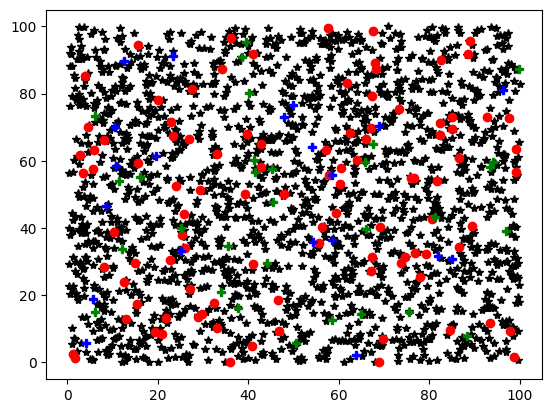

In [17]:
# 'coordlct_x' and 'coordlct_y' represent the coordinates of the facilities.
plt.plot(x_coordCC, y_coordCC, '*', color='black');
plt.plot(x_coordBB, y_coordBB, 'o', color='red');
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green')

In [18]:
# Initialize empty solutions to populate from each iteration of epsilon-constraint method 
optimal_costs = []
optimal_distances = []
detailed_solutions = []


 #Create Model
model = gp.Model("P_Median_Epsilon_Constraint_Style")

I = list(range(nbrblood)) #Open Facilities  
J = list(range(nbrcoll)) #Facilities to be served
H_priv = list(range(nbrprivh))                          
H_pub = list(range(nbrprivh, nbrprivh + nbrpubh))        
H = H_priv + H_pub                                       

 # Define variables:
x = model.addVars(I, J, vtype=GRB.BINARY, name="assign")  # If demand from location i is served by open facility j then x_ij=1 otherwise x_ij=0
y = model.addVars(I, vtype=GRB.BINARY, name="open") # Facility i to open. y_i=0 if closed and y_i=1 if open
z = model.addVars(I, H, vtype=GRB.BINARY, name="deliver") # Deliver from blood banks to hospitals

 # Define objective functions

 # Minimize total distance from demands to the nearest open facilities
 # Each demand location j must be assigned to exactly one facility i
model.addConstrs((gp.quicksum(x[i, j] for i in I) == 1 for j in J), name="assign_once")
 # The demand from location i can only be assigned to an open facility j
model.addConstrs((x[i, j] <= y[i] for i in I for j in J), name="only_open")
model.addConstr(gp.quicksum(y[i] for i in I) == nbrblood, name="open_facilities")

model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) >= 0.9*328*10, name="lower_bound_sum")

# model.addConstr(gp.quicksum(q_c[i] * x[i, j] for i in I for j in J) <= 328*1.1*10, name="upper_bound_sum")

model.addConstrs((gp.quicksum(x[i, j] for j in J) <= q_b[i] * y[i] for i in I), name="capacity_constraints")  # Capacity constraints for each bank

# Generate random blood collection amounts and capacities
q_c = np.random.randint(1, 10, nbrcoll)  # Amount of blood collected at each CC
g_b = np.random.randint(50, 100, nbrblood)  # Min blood required at each bank
q_b = np.random.randint(100, 200, nbrblood)  # Max capacity at each bank


f_bc = 0.094*2.61
model.addConstr(gp.quicksum(f_bc*distancelct[i][j] * x[i, j] for i in I for j in J) <= 100000, name="budget_constraint")

# # Add constraints for blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for i in I) == 1 for h in H), name="deliver_once")  # Each hospital must receive blood from exactly one bank
model.addConstrs((z[i, h] <= y[i] for i in I for h in H), name="only_open_delivery")  # Blood can only be delivered from open banks 
model.addConstrs((gp.quicksum(z[i, h] for i in I) <= q_c[h] for h in H), name="delivery_capacity")  # Capacity constraints for each hospital
# # Add constraints for maximum blood delivery to hospitals
model.addConstrs((gp.quicksum(z[i, h] for h in H) <= q_c[i] for i in I), name="max_blood_delivery")  # Maximum blood delivery from each bank

# For each blood bank k, and each pair of assigned CCs (i, j), define:
# u[k, i, j] = 1 if blood bank k travels from CC i to CC j, 0 otherwise

u = model.addVars(nbrblood, nbrcoll, nbrcoll, vtype=GRB.BINARY, name="route")
for k in range(nbrblood):
    for i in range(nbrcoll):
        model.addConstr(gp.quicksum(u[k, i, j] for j in range(nbrcoll) if j != i) == x[k, i])
        model.addConstr(gp.quicksum(u[k, j, i] for j in range(nbrcoll) if j != i) == x[k, i])
# Add continuous variables for MTZ
mtz = model.addVars(nbrblood, nbrcoll, vtype=GRB.CONTINUOUS, lb=0, ub=nbrcoll, name="mtz")

for k in range(nbrblood):
    for i in range(1, nbrcoll):
        for j in range(1, nbrcoll):
            if i != j:
                model.addConstr(mtz[k, i] - mtz[k, j] + nbrcoll * u[k, i, j] <= nbrcoll - 1)

model.setObjective(
    gp.quicksum(x[i, j] * distancelct[i][j] for i in I for j in J) +
    gp.quicksum(z[i, h] * distanceBB_priv[i][h] for i in I for h in H_priv) +
    gp.quicksum(z[i, h] * distanceBB_pub[i][h - nbrprivh] for i in I for h in H_pub)+
    gp.quicksum(u[k, i, j] * np.linalg.norm(np.array(comm_coords[i]) - np.array(comm_coords[j]))
               for k in range(nbrblood) for i in range(nbrcoll) for j in range(nbrcoll) if i != j),
    GRB.MINIMIZE
)

model.setParam('Heuristics', 0)
# # # Optimize the model
model.optimize()

# Check if a solution was found
if model.status == gp.GRB.OPTIMAL:
    print(f"Optimal objective value: {model.objVal}")

    # Print values of decision variables
    for var in model.getVars():
        if var.X > 1e-6:  # print only non-zero values
            print(f"{var.VarName} = {var.X}")
else:
    print("No optimal solution found.")

# After model.optimize() and extracting x_vals
assignments = {idx: [] for idx in I}
for idx in I:
    for j in J:
        if x[idx, j].X > 0.5:
            assignments[idx].append(j)




MemoryError: 

Solution 1:
  Objective Value: 14883.9561889996
  TSP Distance: 88924.46900167273
  Assignments:
    Blood Bank 0: Assigned CCs [315, 419, 1014, 1270, 1343, 1619, 1679, 2519, 2826, 2912, 2988, 3101, 3325, 3432]
    Blood Bank 1: Assigned CCs [373, 1214, 1475, 3457, 3538, 3753]
    Blood Bank 2: Assigned CCs [222, 311, 433, 846, 899, 995, 1338, 1593, 1621, 1762, 1929, 2049, 2426, 2739, 3058, 3198, 3228, 3717, 3942]
    Blood Bank 3: Assigned CCs [11, 241, 408, 473, 748, 785, 836, 917, 1180, 1322, 1355, 1367, 1370, 1415, 1781, 1854, 2053, 2100, 2254, 2304, 2621, 3334, 3838, 3877]
    Blood Bank 4: Assigned CCs [255, 413, 474, 646, 865, 993, 1656, 1732, 1900, 1917, 2275, 2584, 2746, 3062, 3338, 3429, 3448, 3552, 3878, 3971]
    Blood Bank 5: Assigned CCs [60, 63, 330, 566, 783, 1057, 1266, 1290, 1347, 1504, 1768, 1802, 1918, 2162, 2683, 2750, 3517, 3614, 3816]
    Blood Bank 6: Assigned CCs [86, 278, 331, 388, 399, 630, 798, 800, 1107, 1724, 1796, 1856, 1902, 1904, 2260, 2631, 2668, 2815,

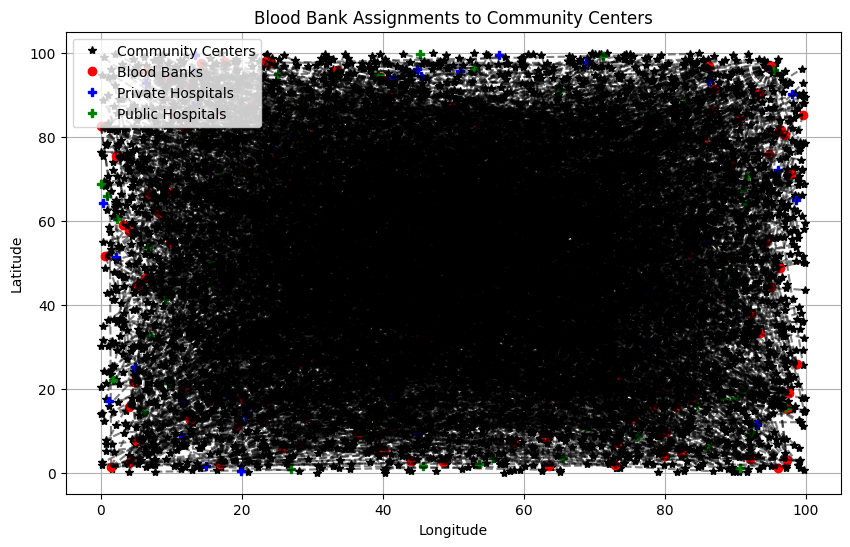

Optimal Costs: [14883.9561889996]
Optimal Distances: [np.float64(88924.46900167273)]
Solution 1:
  Objective Value: 14883.9561889996
  TSP Distance: 88924.46900167273
  Assignments:
    Blood Bank 0: Assigned CCs [315, 419, 1014, 1270, 1343, 1619, 1679, 2519, 2826, 2912, 2988, 3101, 3325, 3432]
    Blood Bank 1: Assigned CCs [373, 1214, 1475, 3457, 3538, 3753]
    Blood Bank 2: Assigned CCs [222, 311, 433, 846, 899, 995, 1338, 1593, 1621, 1762, 1929, 2049, 2426, 2739, 3058, 3198, 3228, 3717, 3942]
    Blood Bank 3: Assigned CCs [11, 241, 408, 473, 748, 785, 836, 917, 1180, 1322, 1355, 1367, 1370, 1415, 1781, 1854, 2053, 2100, 2254, 2304, 2621, 3334, 3838, 3877]
    Blood Bank 4: Assigned CCs [255, 413, 474, 646, 865, 993, 1656, 1732, 1900, 1917, 2275, 2584, 2746, 3062, 3338, 3429, 3448, 3552, 3878, 3971]
    Blood Bank 5: Assigned CCs [60, 63, 330, 566, 783, 1057, 1266, 1290, 1347, 1504, 1768, 1802, 1918, 2162, 2683, 2750, 3517, 3614, 3816]
    Blood Bank 6: Assigned CCs [86, 278, 331,

In [ ]:
# Store the results for each iteration
optimal_costs.append(model.objVal)
optimal_distances.append(total_tsp_distance)
detailed_solutions.append({
	"objective_value": model.objVal,
	"tsp_distance": total_tsp_distance,
	"assignments": assignments.copy(),
	"tsp_distances": tsp_distances.copy()
})
# Print the detailed solutions
for i, solution in enumerate(detailed_solutions):
	print(f"Solution {i+1}:")
	print(f"  Objective Value: {solution['objective_value']}")
	print(f"  TSP Distance: {solution['tsp_distance']}")
	print("  Assignments:")
	for bank, cc_list in solution['assignments'].items():
		print(f"    Blood Bank {bank}: Assigned CCs {cc_list}")
	print("  TSP Distances:")
	for bank, tsp_dist in solution['tsp_distances'].items():
		print(f"    Blood Bank {bank}: TSP Distance {tsp_dist}")
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_coordCC, y_coordCC, '*', color='black', label='Community Centers')
plt.plot(x_coordBB, y_coordBB, 'o', color='red', label='Blood Banks')
plt.plot(x_coord_privhosp, y_coord_privhosp, 'P', color='blue', label='Private Hospitals')
plt.plot(x_coord_pubhosp, y_coord_pubhosp, 'P', color='green', label='Public Hospitals')			
for i in I:
	if assignments[i]:
		for j in assignments[i]:
			plt.plot([x_coordBB[i], x_coordCC[j]], [y_coordBB[i], y_coordCC[j]], 'k--', alpha=0.5)
plt.title('Blood Bank Assignments to Community Centers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid()
plt.show()
# Display the optimal costs and distances
print("Optimal Costs:", optimal_costs)
print("Optimal Distances:", optimal_distances)
# Display the detailed solutions
for i, solution in enumerate(detailed_solutions):
	print(f"Solution {i+1}:")
	print(f"  Objective Value: {solution['objective_value']}")
	print(f"  TSP Distance: {solution['tsp_distance']}")
	print("  Assignments:")
	for bank, cc_list in solution['assignments'].items():
		print(f"    Blood Bank {bank}: Assigned CCs {cc_list}")
	print("  TSP Distances:")
	for bank, tsp_dist in solution['tsp_distances'].items():
		print(f"    Blood Bank {bank}: TSP Distance {tsp_dist}")
		

C:\Users\65816\AppData\Local\Temp\ipykernel_51416\3258597023.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\65816\AppData\Local\Temp\ipykernel_51416\3258597023.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


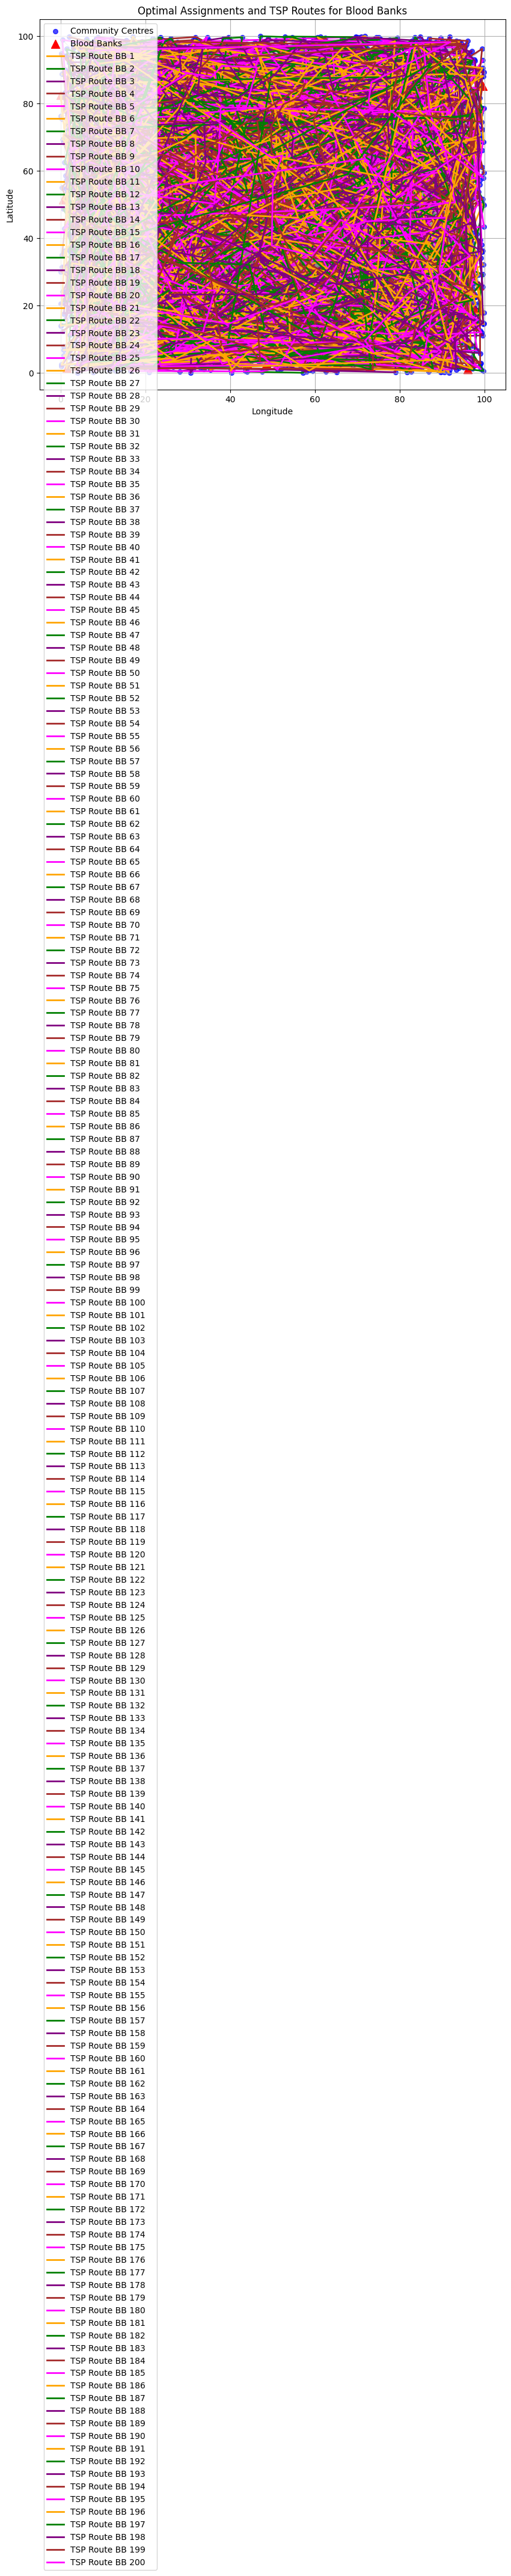

In [ ]:
plt.figure(figsize=(10, 8))

# Plot all community centres and blood banks
plt.scatter([c[0] for c in comm_coords], [c[1] for c in comm_coords], c='blue', label='Community Centres', s=30, alpha=0.7)
plt.scatter([b[0] for b in bank_coords], [b[1] for b in bank_coords], c='red', label='Blood Banks', s=100, marker='^')

# Draw assignment lines (gray)
for i in I:
    for j in assignments[i]:
        bx, by = bank_coords[i]
        cx, cy = comm_coords[j]
        plt.plot([bx, cx], [by, cy], c='gray', linewidth=0.7, alpha=0.5)

# Draw TSP routes (colored)
def tsp_nn_path(start_coord, cc_indices, comm_coords):
    if not cc_indices:
        return [start_coord, start_coord]
    unvisited = set(cc_indices)
    current = start_coord
    path = [start_coord]
    while unvisited:
        nearest = min(unvisited, key=lambda idx: np.linalg.norm(np.array(current) - np.array(comm_coords[idx])))
        current = comm_coords[nearest]
        path.append(current)
        unvisited.remove(nearest)
    path.append(start_coord)
    return path

colors = ['orange', 'green', 'purple', 'brown', 'magenta']
for i in I:
    if assignments[i]:
        start_coord = bank_coords[i]
        cc_indices = assignments[i]
        path = tsp_nn_path(start_coord, cc_indices, comm_coords)
        path_x, path_y = zip(*path)
        plt.plot(path_x, path_y, color=colors[i % len(colors)], linewidth=2, label=f'TSP Route BB {i+1}')

plt.title("Optimal Assignments and TSP Routes for Blood Banks")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
if model.Status == GRB.OPTIMAL or model.Status == GRB.SUBOPTIMAL:
    lower_bound = model.ObjBound
    print(f"Optimal objective lower bound: {lower_bound}")

Optimal objective lower bound: 14883.956188999598
